In [63]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lbc.scenario import Scenario
from lbc.demand_response import DemandResponseProgram
from lbc.policies import RBCPolicy

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
def hr_index(index, hr):
    return np.where(np.array([x.hour for x in index]) == hr)[0][0]

# TOU

In [17]:
dr = DemandResponseProgram("TOU")
s = Scenario(dr_program=dr)

In [10]:
dr.default_config["TOU"]

{'dr_start_time': '12:00:00',
 'dr_end_time': '18:00:00',
 'program_type': 'TOU',
 'program_specific': {'tou_off_peak': 1.0, 'tou_peak': 10.0}}

In [12]:
%autoreload 2
from lbc.policies import RBCPolicy

[(0, 27), (83, 24), (131, 21), (143, 24), (215, 24), (215, 27)]


<AxesSubplot:>

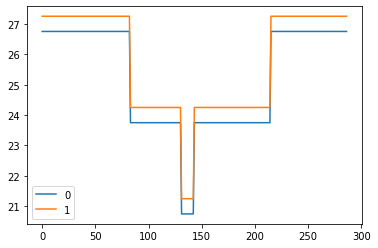

In [19]:
# Comfort start/stop applies to all DR programs
comfort_start = hr_index(s.time_index, hr=7)
comfort_stop = hr_index(s.time_index, hr=18)

# DR start and stop indexes
dr_start = hr_index(s.time_index, hr=12)
dr_stop = hr_index(s.time_index, hr=18)

# Precooling happens 1 hr before DR start
precooling_start = dr_start - 12  # 5 min/step

setpoints = [
    (0, 27),
    (comfort_start, 24),
    (precooling_start, 21), 
    (dr_start, 24),
    (dr_stop, 24),
    (comfort_stop, 27)
]

print(setpoints)

policy = RBCPolicy(
    setpoints=setpoints, scenario=s, p_flow=1., p_temp=.8)

pd.DataFrame(policy.comfort_band).plot()

# PC

In [20]:
dr = DemandResponseProgram("PC")
s = Scenario(dr_program=dr)

dr.default_config["PC"]

{'dr_start_time': '13:00:00',
 'dr_end_time': '17:00:00',
 'program_type': 'PC',
 'program_specific': {'p_limit_dr': 15.0,
  'p_limit_nondr': 25.0,
  'base_price': 1.0,
  'pc_penalty': 10.0}}

[(0, 27), (35, 21), (155, 24), (203, 24), (215, 27)]


<AxesSubplot:>

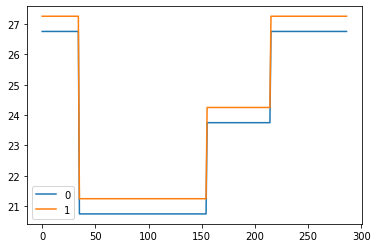

In [91]:
dr_start = hr_index(s.time_index, hr=13)
dr_stop = hr_index(s.time_index, hr=17)

precooling_start = dr_start - 120  # 5 min/step
precooling_stop = dr_start

setpoints = [
    (0, 27),
    #(comfort_start, 24),
    (precooling_start, 21), 
    (dr_start, 24),
    (dr_stop, 24),
    (comfort_stop, 27)
]

print(setpoints)

# policy = RuleBasedControlPolicy(
#     setpoints=setpoints, num_steps=s.num_episode_steps,
#     cooling_p_flow=1., cooling_p_discharge_temp=.8)

policy = RBCPolicy(
    setpoints=setpoints, scenario=s, p_flow=1., p_temp=.8)

pd.DataFrame(policy.comfort_band).plot()

# RTP

In [22]:
dr = DemandResponseProgram("RTP")
s = Scenario(dr_program=dr)

dr.default_config["RTP"]

{'program_type': 'RTP', 'program_specific': {}}

[(0, 27), (83, 24), (131, 21), (143, 24), (215, 27)]


<AxesSubplot:>

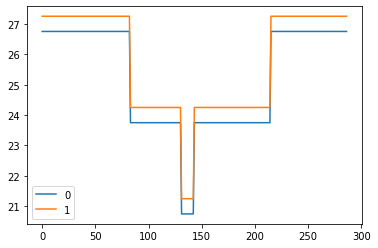

In [65]:
dr_start = hr_index(s.time_index, hr=12)

precooling_start = dr_start - 12  # 5 min/step
precooling_stop = dr_start

setpoints = [
    (0, 27),
    (comfort_start, 24),
    (precooling_start, 21), 
    (dr_start, 24),
    (comfort_stop, 27)
]


print(setpoints)

# policy = RuleBasedControlPolicy(
#     setpoints=setpoints, num_steps=s.num_episode_steps,
#     cooling_p_flow=1., cooling_p_discharge_temp=.8)

policy = RBCPolicy(
    setpoints=setpoints, scenario=s, p_flow=1., p_temp=.8)

pd.DataFrame(policy.comfort_band).plot()

# Use the runner to tune power of pre-cooling

In [117]:
%autoreload 2
from lbc.experiments import RBCRunner

In [118]:
%autoreload 2
from lbc.experiments.config import RBC_SETPOINTS

In [119]:
from lbc.analysis import plot_stats

In [120]:
with open("/projects/aumc/learning-building-control/results-PC/RBC-PC-1.000-0.800.p", "rb") as f:
    data = pickle.load(f)
    
data["config"]["policy_config"]["setpoints"] = RBC_SETPOINTS["PC"]
data["config"]

{'policy_type': 'RBC',
 'policy_config': {'setpoints': [(0, 27),
   (0, 21),
   (155, 26),
   (203, 26),
   (215, 28)],
  'p_flow': 1.0,
  'p_temp': 0.8},
 'batch_size': 31,
 'dr_program': 'PC',
 'scenario_config': {'start_time': '00:05:00',
  'end_time': '23:55:00',
  'zone_temp_init_mean': 26.0,
  'dr_program': <lbc.demand_response.DemandResponseProgram at 0x7f8cc1309b80>},
 'results_dir': '/projects/aumc/dave/learning-building-control/lbc/experiments/results-PC',
 'dry_run': 0,
 'name_ext': None,
 'p_flow': 1.0,
 'p_temp': 0.8}

In [123]:
results = {}
rollouts = {}
for p_flow in np.linspace(0, .3, 10):
    for p_temp in np.linspace(0, 1, 10):
        config = data["config"].copy()
        config["policy_config"]["p_flow"] = p_flow
        config["policy_config"]["p_temp"] = p_temp
        runner = RBCRunner(**config)
        loss, rollout, meta = runner.run_policy()
        loss = loss.mean().detach().numpy()
        power = rollout.data["total_power"].sum()
        results[(p_flow, p_temp)] = (loss, power)
        rollouts[(p_flow, p_temp)] = rollout
        print(p_flow, p_temp, loss, power)

0.0 0.0 24522.084 89352.38
0.0 0.1111111111111111 21447.736 91056.12
0.0 0.2222222222222222 18671.266 92730.516
0.0 0.3333333333333333 16172.233 94396.38
0.0 0.4444444444444444 13941.399 96033.99
0.0 0.5555555555555556 11966.813 97653.72
0.0 0.6666666666666666 10248.401 99237.19
0.0 0.7777777777777777 8787.909 100774.52
0.0 0.8888888888888888 7575.973 102244.12
0.0 1.0 6559.426 103641.984
0.03333333333333333 0.0 14541.117 97862.87
0.03333333333333333 0.1111111111111111 12189.98 99764.74
0.03333333333333333 0.2222222222222222 10200.301 101561.64
0.03333333333333333 0.3333333333333333 8585.208 103225.18
0.03333333333333333 0.4444444444444444 7287.846 104720.38
0.03333333333333333 0.5555555555555556 6243.5435 106106.54
0.03333333333333333 0.6666666666666666 5428.739 107404.57
0.03333333333333333 0.7777777777777777 4790.25 108674.695
0.03333333333333333 0.8888888888888888 4294.5347 109872.27
0.03333333333333333 1.0 3871.4866 111048.69
0.06666666666666667 0.0 9333.462 105327.68
0.0666666666

In [112]:
# for key, rollout in rollouts.items():
#     fig, ax = plot_stats(rollout, "total_power")
#     ax.set_title(key)

In [113]:
x = [x[0] for x in list(results.values())]
np.argmin(x), min(x)

(9, array(6062.4844, dtype=float32))

In [114]:
list(results.keys())[9]

(0.0, 1.0)

(<Figure size 360x216 with 1 Axes>, <AxesSubplot:xlabel='Date/Time'>)

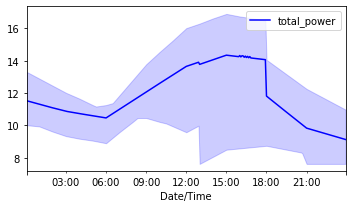

In [115]:
plot_stats(rollouts[(0.0, 1.0)], "total_power")

(<Figure size 360x216 with 1 Axes>, <AxesSubplot:xlabel='Date/Time'>)

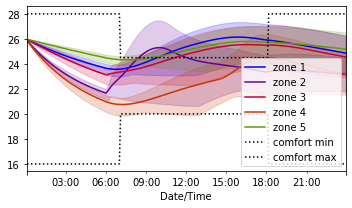

In [116]:
plot_stats(rollouts[(0.0, 1.0)], "zone_temp")